# Compare embeddings of baseline vs. finetuned GST

### Imports

In [1]:
from inference.face_voice_inference import FaceStyleInference
from pathlib import Path
import IPython
from inference.tacotron_loader import TacotronLoader
from parallel_wavegan.utils import load_model, download_pretrained_model
import soundfile as sf
import torch
import numpy as np
from random import shuffle
from espnet2.tasks.tts import TTSTask
from umap.umap_ import UMAP
import matplotlib.pyplot as plt

### Load base and finetuned model

In [2]:
face_style = FaceStyleInference(
    facevoice_model_path="../results/silver-star-64/facestyle-epoch=09-val_loss=0.00.ckpt",
    facenet_pretrained="casia-webface",
    facenet_finetuned="../results/facenet/spring-glitter-9/facestyle-epoch=14-val_loss=0.07.ckpt"
)
face_model = face_style.facestyle
baseline_tacotron, preprocess = TacotronLoader.load()

- Loaded Facestyle model from : ../results/silver-star-64/facestyle-epoch=09-val_loss=0.00.ckpt
  using finetuned Facenet model from ../results/facenet/spring-glitter-9/facestyle-epoch=14-val_loss=0.07.ckpt
- Loaded Tacotron2 model
- Loaded ParallelWaveGAN


In [3]:
config_weights = {
    "train_config" : "/home/bjorn/code/full_espnet/espnet/egs2/lrs3/tts1/exp_new/tts_train_fbank_phn_tacotron_g2p_en_no_space/config.yaml",
    "model_file" : "/home/bjorn/code/full_espnet/espnet/egs2/lrs3/tts1/exp2/tts_train_fbank_phn_tacotron_g2p_en_no_space/3epoch.pth"
}
tt2, train_args = TTSTask.build_model_from_file(
    config_weights["train_config"], config_weights["model_file"], "cuda"
)
_ = tt2.eval()

Load the 20 speakers with the most samples (for validation set) and choose 10 at random. Select 50 samples from each of these speakers to continue with.

In [4]:
total = 10
per_spk = 50
paths = []
wav_paths = []
images_path = Path("../data/images/train")
audio_path = Path("/mnt/U/Datasets/lrs3pretrain/processed/audio_segments/pretrain")
spks = list(images_path.glob("*"))
spk_count = []
for spk in spks:
    spk_count.append((spk, len(list(spk.glob("*")))))
spk_count = sorted(spk_count, key=lambda x: x[1], reverse=True)[:20]
spks = [x for x, y in spk_count]
shuffle(spks)
for speaker in spks[:total]:
    new_paths = list(speaker.glob("*.jpg"))[:per_spk]
    wavs = map(lambda x: audio_path / speaker.stem / (x.stem.split("_")[0]+ "_" + str(int(x.stem.split("_")[1])-1) + ".wav"), new_paths)
    #wavs = map(lambda x: audio_path / speaker.stem / (x.stem.split("_")[0]+ ".wav"), new_paths)
    paths += new_paths
    wav_paths += wavs
speakers = list(map(lambda wav_fpath: wav_fpath.parent.stem, paths))

In [5]:
def read_audio(path):
    speech, fs = sf.read(path)
    speech = torch.from_numpy(speech).float().cuda()
    if baseline_tacotron.feats_extract is not None:
        feats = baseline_tacotron.feats_extract(speech[None])[0][0]
    else:
        feats = speech
    return tt2.normalize(feats[None])[0][0]

In [9]:
face_embs = np.zeros((len(paths), 512), dtype=np.float64)
voice_embs = np.zeros((len(paths), 512), dtype=np.float64)
with torch.no_grad():
    for i, path in enumerate(paths):
        baseline_audio_path = wav_paths[i]
        voice_embs[i] = baseline_tacotron.tts.gst(read_audio(baseline_audio_path).unsqueeze(0)).squeeze(0).cpu().numpy() 
        img = face_style.load_image(path)
        #face_embs[i] = face_model.forward(img.unsqueeze(0)).squeeze(0).cpu().numpy() 
        face_embs[i] = tt2.tts.gst(read_audio(baseline_audio_path).unsqueeze(0)).squeeze(0).cpu().numpy() 

Plotting code based on [Resemblyzer](https://github.com/resemble-ai/Resemblyzer/blob/master/demo_utils.py) demo utils.

In [21]:
def plot_umap(voice_embs, face_embs, speakers, **kwargs):
    colors = np.array([
        [0, 127, 70],
        [255, 0, 0],
        [255, 217, 38],
        [0, 135, 255],
        [165, 0, 165],
        [255, 167, 255],
        [97, 142, 151],
        [0, 255, 255],
        [255, 96, 38],
        [142, 76, 0],
        [33, 0, 127],
        [0, 0, 0],
        [183, 183, 183],
        [76, 255, 0],
    ], dtype=float) / 255 
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
    
    reducer = UMAP(**kwargs) 
    all_embs = np.concatenate([voice_embs, face_embs], axis=0)
    projs = reducer.fit_transform(all_embs)
    projs, projs2 = projs[:len(voice_embs)], projs[len(voice_embs):]
    ax1.tick_params(left=False,
                bottom=False,
                labelleft=False,
                labelbottom=False)
    ax2.tick_params(left=False,
                bottom=False,
                labelleft=False,
                labelbottom=False)

    speakers = np.array(speakers)
    for i, speaker in enumerate(np.unique(speakers)):
        speaker_projs = projs[speakers == speaker]
        speaker_projs2 = projs2[speakers == speaker]

        marker = "o"
        label = f"Speaker {i+1}"
        ax1.scatter(*speaker_projs.T,s=50, c=[colors[i]], marker=marker, label=label)
        ax2.scatter(*speaker_projs2.T, s=50, c=[colors[i]], marker=marker)


    plt.tight_layout()
    fig.legend(loc='center left', fontsize="x-large")
    ax1.set_title("Baseline GST", fontsize="xx-large")
    ax2.set_title("Finetuned GST", fontsize="xx-large")

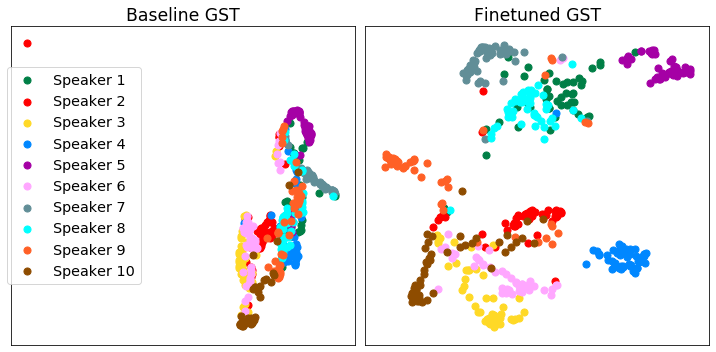

In [26]:
_ = plot_umap(voice_embs, face_embs, speakers, min_dist=0.3)
plt.tight_layout()
plt.savefig("./plots/baseline_vs_finetuned.pdf")
plt.show()